# Breast Cancer Classification Project

This notebook presents an end-to-end machine learning pipeline for classifying breast cancer (malignant vs. benign) using the Wisconsin Diagnostic Breast Cancer dataset. The pipeline includes data loading, exploration, preprocessing, model training, evaluation, and interpretation.

## 1.  Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
import warnings
warnings.filterwarnings('ignore')


## 2.  Load and Inspect Dataset

In [2]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df['target'] = df['target'].map({0: 'malignant', 1: 'benign'})
df.head()


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33           184.60      2019.0   
1                 0.05667  ...          23.41           158.80      1956.0   
2                 0.05999  ...          25.53           152.50      1709.0   
3                 0.09744  ...          26.50            98.87       567.7   
4                 0.05883  ...          16.67           152.20      1575.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   worst symmetry  worst fractal dimension     target  
0          0.4601                  0.11890  malignant  
1          0.2750                  0.08902  malignant  
2          0.3613                  0.08758  malignant  
3          0.6638                  0.17300  malignant  
4          0.2364                  0.07678  malignant  

[5 rows x 31 columns]

## 3.  Data Exploration (EDA)
Explore class distribution and feature scales.

target
benign       357
malignant    212
Name: count, dtype: int64


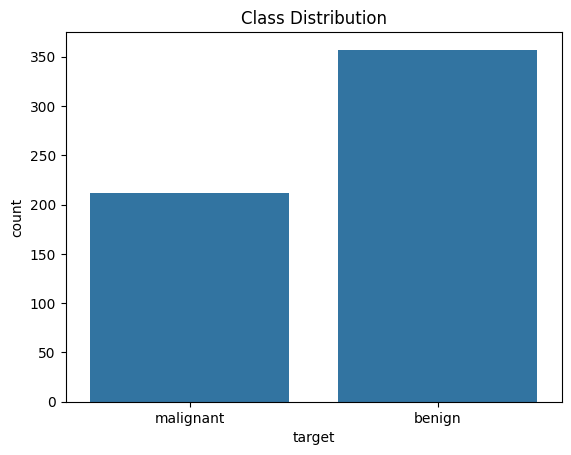

mean         std      min     max
worst area       880.583128  569.356993  185.200  4254.0
mean area        654.889104  351.914129  143.500  2501.0
area error        40.337079   45.491006    6.802   542.2
worst perimeter  107.261213   33.602542   50.410   251.2
mean perimeter    91.969033   24.298981   43.790   188.5

In [3]:
print(df['target'].value_counts())
sns.countplot(x='target', data=df)
plt.title("Class Distribution")
plt.show()

df.describe().T[['mean', 'std', 'min', 'max']].sort_values(by='std', ascending=False).head()


## 4.  Feature Selection

In [4]:
X = df.drop('target', axis=1)
y = (df['target'] == 'malignant').astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())


Selected Features: ['mean radius', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']


## 5. Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


## 6. Model Training (Logistic, Random Forest, SVM)

In [6]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(probability=True)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"AUC: {auc:.3f}")



Logistic Regression
[[69  2]
 [ 1 42]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

AUC: 0.998

Random Forest
[[69  2]
 [ 3 40]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

AUC: 0.993

SVM
[[70  1]
 [ 3 40]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro

## 7. Baseline (Majority Class Classifier)

In [7]:
from sklearn.dummy import DummyClassifier
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
baseline_preds = baseline.predict(X_test)
print(confusion_matrix(y_test, baseline_preds))
print(classification_report(y_test, baseline_preds))


[[71  0]
 [43  0]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        71
           1       0.00      0.00      0.00        43

    accuracy                           0.62       114
   macro avg       0.31      0.50      0.38       114
weighted avg       0.39      0.62      0.48       114



## 8. Save Best Model

In [9]:
joblib.dump(models["Random Forest"], "random_forest_model.joblib")


['random_forest_model.joblib']

## 9. Conclusion
This notebook completes the basic ML pipeline including EDA, feature selection, model training, evaluation, and saving. Next step: model interpretability with SHAP.